<a href="https://colab.research.google.com/github/YolandaZhao10/CSCI-6170-Project-in-AI-and-ML/blob/main/hw2/homework_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
from scipy.stats import ttest_rel
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

from google.colab import drive

In [12]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/framingham.csv'
df = pd.read_csv(file_path)
print(f"Dataset loaded successfully from Google Drive with {df.shape[0]} rows and {df.shape[1]} columns.")
print(df.head())
print(df.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded successfully from Google Drive with 4238 rows and 16 columns.
   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3  

# Task 1 (30 points): Implement a Decision Tree Classifier for your classification problem. You may use a built-in package to implement your classifier. Additionally, do the following

## Visualize the decision tree structure for at least three different parameter settings. Comment on how the depth and complexity change the tree.

In [13]:
# Drop rows with missing values
df.dropna(inplace=True)

# Define features (X) and target (y)
X = df.drop('TenYearCHD', axis=1)
y = df['TenYearCHD']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2924, 15)
X_test shape: (732, 15)
y_train shape: (2924,)
y_test shape: (732,)


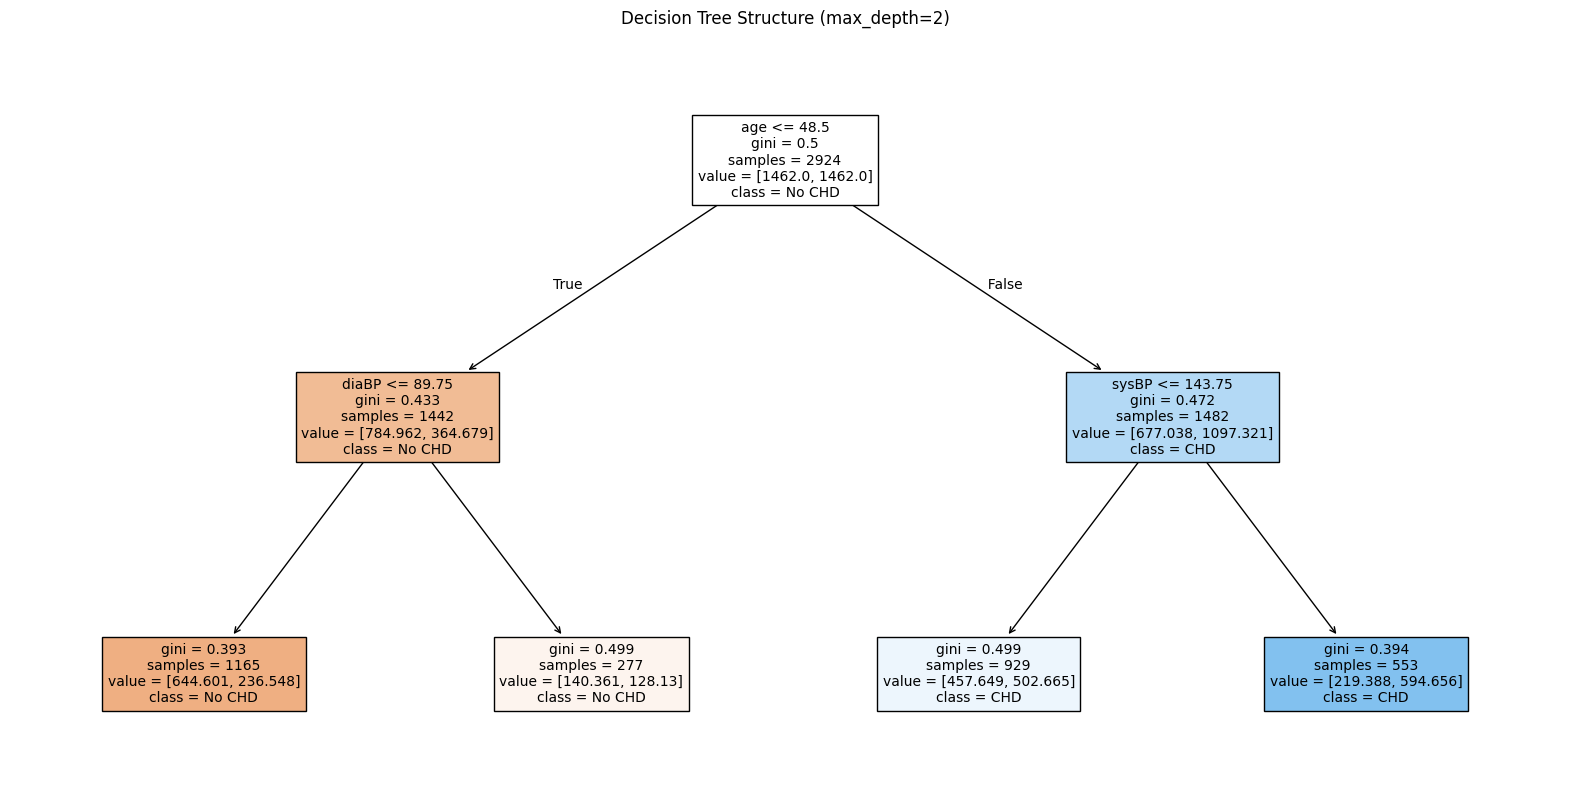

Model (max_depth=2): Actual Depth = 2, Leaves = 4



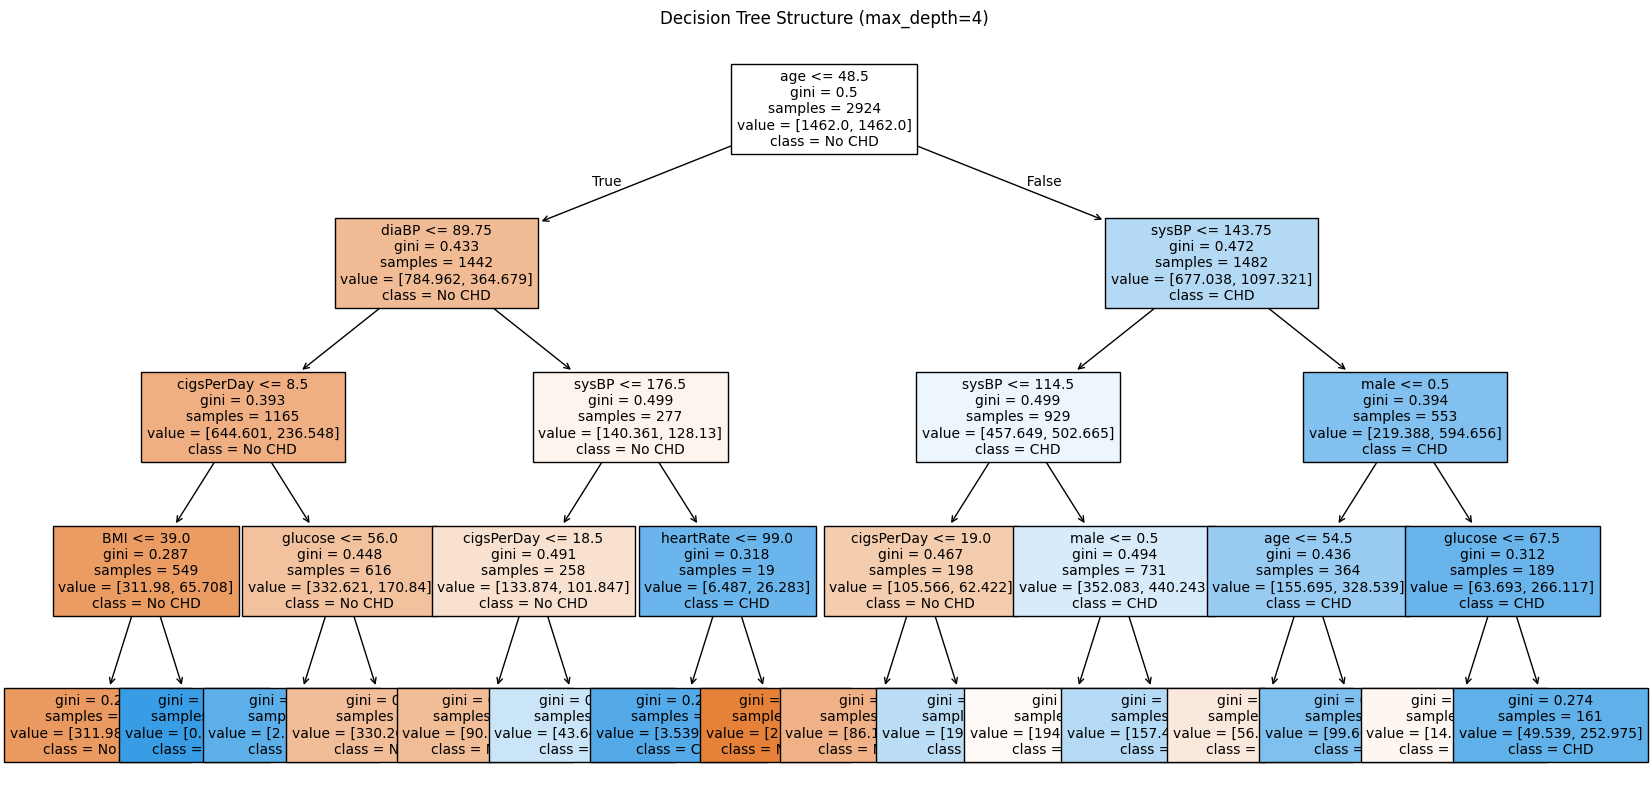

Model (max_depth=4): Actual Depth = 4, Leaves = 16



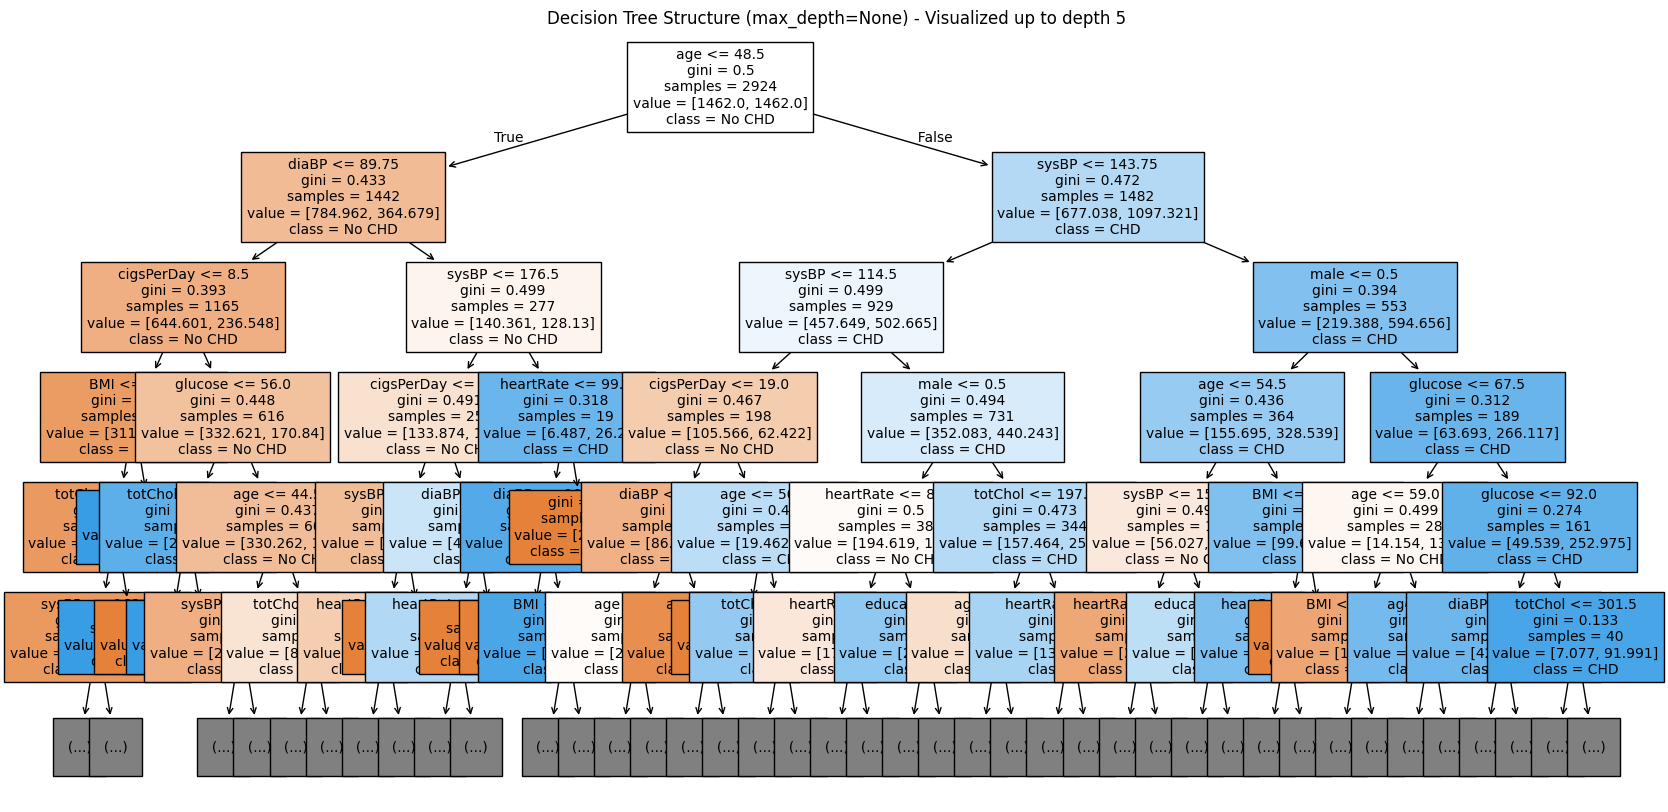

Model (max_depth=None): Actual Depth = 21, Leaves = 479



In [14]:
depths = [2, 4, None]
models = []

for depth in depths:
    clf = DecisionTreeClassifier(class_weight="balanced", max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)
    models.append(clf)

    plt.figure(figsize=(20, 10))
    vis_depth = depth if depth is not None else 5
    title = f"Decision Tree Structure (max_depth={depth})"
    if depth is None:
        title += " - Visualized up to depth 5"

    plot_tree(clf,
              filled=True,
              feature_names=X.columns,
              class_names=['No CHD', 'CHD'],
              max_depth=vis_depth,
              fontsize=10)
    plt.title(title)
    plt.show()

    # Print structural details
    print(f"Model (max_depth={depth}): Actual Depth = {clf.get_depth()}, Leaves = {clf.get_n_leaves()}\n")

From the three decision tree visualizations, we can see a strong relationship between the allowed depth and the overall model complexity.

### max_depth = 2 (very shallow tree)

The tree contains only a few splits (actual depth = 2, leaves = 4). It mainly uses the most dominant features (e.g., age, diaBP, sysBP) and forms coarse decision rules. This makes the model highly interpretable since the full decision process can be described using only a few conditions. However, because the tree cannot model deeper feature interactions, it may fail to capture more intricate patterns in the dataset, leading to underfitting (high bias).

### max_depth = 4 (moderate depth)

When the maximum depth is increased, the decision tree becomes noticeably more complex (actual depth = 4, leaves = 16). Additional features begin to appear in lower levels (e.g., cigsPerDay, BMI, glucose, heartRate, male), allowing the model to learn more specific and detailed rules. This increases model flexibility and helps represent more complex decision boundaries. At the same time, interpretability decreases because there are more paths from root to leaf and the decision process becomes harder to summarize.

### max_depth = None (unrestricted depth)

With no restriction on depth, the tree grows extremely large (actual depth = 21, leaves = 479). It keeps splitting until it can separate small subsets of the training samples, creating many long and highly specific decision rules. While this may improve training accuracy, it often means the model is capturing noise rather than generalizable structure, which greatly increases the risk of overfitting (high variance). In this case, interpretability becomes very poor since the tree is too large to meaningfully analyze as a set of human-readable rules.

### Overall conclusion:
As depth increases, the tree becomes deeper and contains more nodes/leaves, meaning higher complexity and lower bias, but also higher variance and reduced interpretability. Shallow trees produce simpler decision rules, while deeper trees can capture subtle feature interactions but are much more prone to overfitting.

## Do some research on what sensitivity analysis is and how it is performed (include citations). Perform a sensitivity analysis to measure the impact of at least two input features on your model's decision boundary.

### Sensitivity Analysis
**Sensitivity analysis (SA)** is a technique used to determine how changes in a model’s inputs affect its outputs. In other words, it measures how **sensitive the model predictions** are when we vary the values of input features. Sensitivity analysis is important for model interpretability because it helps explain which features most influence predictions, whether the model is robust, and how the decision boundary changes when key inputs change.

In general scientific modeling, sensitivity analysis is often defined as evaluating how uncertainty or variation in model inputs contributes to variation in model outputs. Sensitivity analysis can be categorized into **local sensitivity analysis** (small perturbations around a fixed point) and **global sensitivity analysis** (studying the impact of features over a wide input range). A well-known global method is **variance-based sensitivity analysis** (e.g., Sobol indices), which quantifies how much each input feature contributes to the output variance.

### How Sensitivity Analysis is Performed
In machine learning (including decision trees), sensitivity analysis is often performed using practical model inspection approaches, such as:

#### (a) Permutation importance (quantitative sensitivity)
**Permutation importance** evaluates sensitivity by shuffling a feature column while keeping all other features unchanged. If shuffling a feature causes a large drop in predictive performance, then the model is sensitive to that feature. This method is model-agnostic and is implemented in scikit-learn.

#### (b) Decision boundary / Partial Dependence Visualization (qualitative sensitivity)
To measure the impact of features on the **model’s decision boundary**, we can vary one or two features across a range while fixing all other features (for example, at their mean). This produces a 2D probability surface and allows us to observe where the classification boundary (e.g., probability = 0.5 contour) occurs. This is closely related to **partial dependence plots (PDP)**, which visualize how predictions change with respect to certain features.

### Sensitivity Analysis Experiment (two input features)
To perform sensitivity analysis on the decision tree classifier, we apply two complementary approaches:

1. **Permutation importance**: measures feature sensitivity quantitatively.
2. **Decision boundary visualization (2D slice)**: measures feature sensitivity visually by observing how the boundary changes.


#### Step A — Permutation importance (Sensitivity Score)


In [17]:
clf = DecisionTreeClassifier(class_weight="balanced", ccp_alpha=0.005, random_state=42)
clf.fit(X_train, y_train)

result = permutation_importance(
    clf, X_test, y_test,
    n_repeats=20,
    random_state=42,
    scoring="accuracy"
)

importances = result.importances_mean
stds = result.importances_std
idx = np.argsort(importances)[::-1]
feature_names = X.columns

print("Top features by permutation importance:")
for i in idx:
    print(f"{feature_names[i]:<15} Importance={importances[i]:.4f} ± {stds[i]:.4f}")

Top features by permutation importance:
age             Importance=0.0779 ± 0.0114
heartRate       Importance=0.0000 ± 0.0000
glucose         Importance=0.0000 ± 0.0000
diaBP           Importance=0.0000 ± 0.0000
sysBP           Importance=0.0000 ± 0.0000
totChol         Importance=0.0000 ± 0.0000
BMI             Importance=0.0000 ± 0.0000
diabetes        Importance=0.0000 ± 0.0000
prevalentHyp    Importance=0.0000 ± 0.0000
BPMeds          Importance=0.0000 ± 0.0000
prevalentStroke Importance=0.0000 ± 0.0000
cigsPerDay      Importance=0.0000 ± 0.0000
currentSmoker   Importance=0.0000 ± 0.0000
education       Importance=0.0000 ± 0.0000
male            Importance=0.0000 ± 0.0000


#### Step B — Select two features for decision boundary sensitivity

In [18]:
f1 = "age"
f2 = "heartRate"

i1 = feature_names.get_loc(f1)
i2 = feature_names.get_loc(f2)
print(f"Feature indices: {i1}, {i2}")


Feature indices: 1, 13


#### Step C — 2D decision boundary slice (two-feature sensitivity)
This visualization varies two features over a grid while holding the remaining features fixed at their average values. The contour line at probability 0.5 represents the decision boundary.

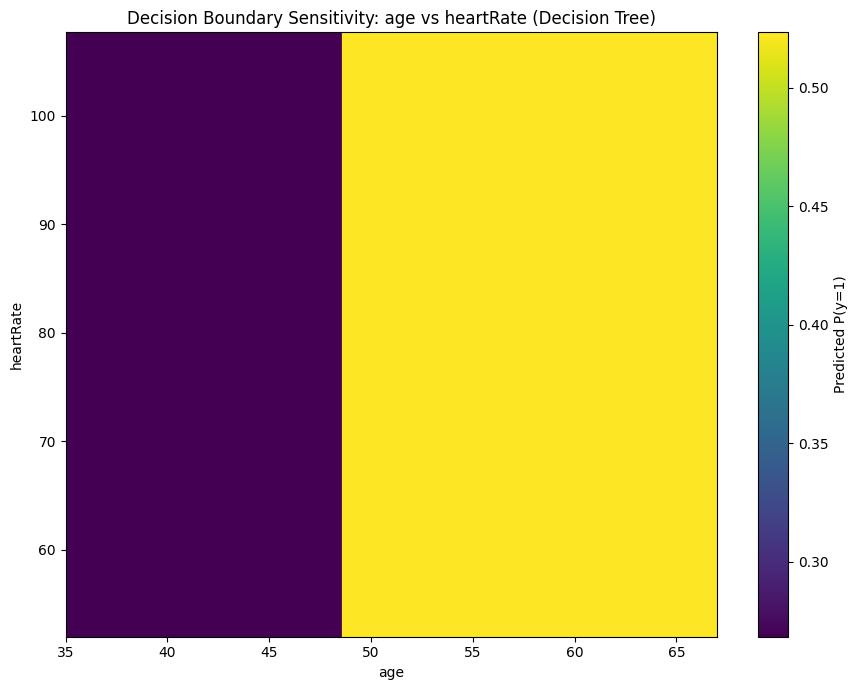

In [19]:
x0 = np.mean(X_test, axis=0)

f1_vals = X_test[f1]
f2_vals = X_test[f2]

f1_grid = np.linspace(np.percentile(f1_vals, 1), np.percentile(f1_vals, 99), 200)
f2_grid = np.linspace(np.percentile(f2_vals, 1), np.percentile(f2_vals, 99), 200)

F1, F2 = np.meshgrid(f1_grid, f2_grid)

grid = np.tile(x0, (F1.size, 1))
grid[:, i1] = F1.ravel()
grid[:, i2] = F2.ravel()

proba = clf.predict_proba(grid)[:, 1].reshape(F1.shape)

plt.figure(figsize=(9, 7))
plt.contour(F1, F2, proba, levels=[0.5], linewidths=2)
plt.imshow(
    proba,
    origin="lower",
    aspect="auto",
    extent=[f1_grid.min(), f1_grid.max(), f2_grid.min(), f2_grid.max()]
)
plt.colorbar(label="Predicted P(y=1)")
plt.xlabel(f1)
plt.ylabel(f2)
plt.title(f"Decision Boundary Sensitivity: {f1} vs {f2} (Decision Tree)")
plt.tight_layout()
plt.show()


### What this shows (Decision Boundary Sensitivity: age vs heartRate)

- This figure visualizes how the Decision Tree’s predicted probability $P(y=1)$ changes as we vary age (x-axis) and heartRate (y-axis), while keeping all other input features fixed (typically at their mean/median values).

- The plot shows a **sharp vertical decision boundary around age $\approx 48.5$:
  - For age < 48.5, the predicted probability is consistently low (purple region).
  - For age $\ge$ 48.5, the predicted probability becomes higher (yellow region).

- The color remains almost constant along the heartRate axis, indicating that heartRate has little influence on the model’s predictions in this slice compared to age.

- The boundary appears straight and blocky, which is expected for decision trees because they use axis-aligned threshold splits.



### Conclusion (Sensitivity Analysis Findings)
- Permutation importance provides a quantitative sensitivity score, showing which features most strongly influence prediction quality.
- The 2D decision boundary slice visually demonstrates how predictions shift and where the classification boundary lies when two key features vary.
- Overall, decision trees show sensitivity through sharp boundary changes because their splitting strategy relies on discrete threshold-based rules.


### References
[1] A. Saltelli, “Sensitivity analysis for importance assessment,” *Risk Analysis*, vol. 22, no. 3, pp. 579–590, 2002.  

[2] I. M. Sobol, “Sensitivity estimates for nonlinear mathematical models,” *Mathematical Modeling and Computational Experiment*, vol. 1, pp. 407–414, 1993.  

[3] Scikit-learn Developers, “Permutation feature importance,” *scikit-learn Documentation*. [Online]. Available: https://scikit-learn.org/stable/modules/permutation_importance.html. Accessed: Feb. 2, 2026.  

[4] C. Molnar, *Interpretable Machine Learning*, 2nd ed., 2022. [Online]. Available: https://christophm.github.io/interpretable-ml-book/pdp.html. Accessed: Feb. 2, 2026.  

[5] Scikit-learn Developers, “Partial dependence plots,” *scikit-learn Documentation*. [Online]. Available: https://scikit-learn.org/stable/modules/partial_dependence.html. Accessed: Feb. 2, 2026.  


# Task 2 (30 points): From the Bagging and Boosting ensemble methods pick any one algorithm from each category. Implement both the algorithms using the same data.


### 1) Algorithms chosen
- Bagging method: `BaggingClassifier` (base estimator: Decision Tree) — fits many base learners on bootstrapped subsets and aggregates predictions (majority vote), often reducing variance.
- Boosting method: `AdaBoostClassifier` (base estimator: shallow Decision Tree stump) — trains learners sequentially and focuses more on previously misclassified samples via sample weighting.

### 2) Stratified k-fold cross-validation (what it is + why)
**StratifiedKFold** is a variant of K-Fold that preserves the **class distribution** in each fold, which is important for classification (especially when classes are not perfectly balanced).
We will run StratifiedKFold with **three different fold counts**: **5, 10, 15**.

### Why these metrics?
- **Accuracy**: measures overall correctness (percentage of correctly classified samples).
- **Precision**: among predicted positive samples, how many are truly positive (useful when **false positives are costly**).
- **F1-score**: harmonic mean of precision and recall; balances precision/recall trade-off.  
Scikit-learn supports evaluating multiple metrics directly in `cross_validate`.

## 3) Commentary: behavior under metrics + ranking changes

### How Bagging typically behaves
- **Bagging** reduces **variance** by averaging/voting across many models trained on different bootstrap samples.
- It often improves **stability** (less sensitivity to noisy splits) and can yield strong **accuracy** and **F1** when the base learner (decision tree) is high-variance.

### How AdaBoost typically behaves
- **AdaBoost** is **sequential**: later learners focus on mistakes from earlier learners by reweighting misclassified samples.  
- It can achieve very strong performance, but may be more sensitive to **noise/outliers**, since difficult samples may be emphasized repeatedly.


### Does the performance ranking change by metric?
Yes, it can. Common reasons include:

1. **Accuracy vs Precision/F1 emphasize different errors.**  
   A model may have high accuracy but lower precision if it produces more false positives (or vice versa).

2. **Decision threshold effects (probabilities → class).**  
   If probability distributions differ across models, the default decision threshold (0.5) can favor one metric over another.

3. **Boosting often shifts the decision boundary.**  
   By focusing on hard cases, AdaBoost can increase recall (thus improving F1) while sometimes reducing precision, or the opposite depending on the dataset.

### What to write after you see your results table

From the stratified k-fold cross-validation results with **5, 10, and 15 folds**, the performance ranking between **AdaBoost(stumps)** and **Bagging(DT)** differs depending on the evaluation metric.

- **Accuracy ranking:** `AdaBoost(stumps) > Bagging(DT)`  
  AdaBoost achieves slightly higher mean accuracy across all fold settings (≈0.848–0.849 vs ≈0.843–0.844). This suggests AdaBoost makes more correct predictions overall.

- **Precision ranking:** `AdaBoost(stumps) > Bagging(DT)`  
  AdaBoost shows consistently higher precision, meaning that among the samples predicted as positive, a larger fraction are truly positive. This indicates AdaBoost produces fewer false positives compared to Bagging in this dataset.

- **F1 ranking:** `Bagging(DT) > AdaBoost(stumps)`  
  Bagging has a much higher F1 score (≈0.159–0.168) compared to AdaBoost (≈0.034–0.045). Since F1 balances precision and recall, this result indicates AdaBoost likely has very low recall (it predicts positives very conservatively), causing its F1 score to drop even though precision is high.

- **Did ranking change?** **Yes.**  
  The best model under **accuracy and precision** is AdaBoost, but the best model under **F1** is Bagging. This happens because **accuracy measures overall correctness**, while **precision and F1 emphasize different types of errors**. In particular, F1 depends strongly on both precision and recall, so a model with high precision but very low recall can still have a poor F1 score.


### References

[1] Scikit-learn Developers, “StratifiedKFold,” *scikit-learn Documentation*. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html. Accessed: Feb. 2026.  

[2] Scikit-learn Developers, “BaggingClassifier,” *scikit-learn Documentation*. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html. Accessed: Feb. 2026.  

[3] Scikit-learn Developers, “AdaBoostClassifier,” *scikit-learn Documentation*. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html. Accessed: Feb. 2026.  

[4] Scikit-learn Developers, “Cross-validation: evaluating estimator performance,” *scikit-learn Documentation*. [Online]. Available: https://scikit-learn.org/stable/modules/cross_validation.html. Accessed: Feb. 2026.  

[5] Scikit-learn Developers, “Model evaluation: quantifying the quality of predictions,” *scikit-learn Documentation*. [Online]. Available: https://scikit-learn.org/stable/modules/model_evaluation.html. Accessed: Feb. 2026.  

[6] Scikit-learn Developers, “f1_score,” *scikit-learn Documentation*. [Online]. Available: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html. Accessed: Feb. 2026.


In [20]:
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),
    n_estimators=200,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),  # stump
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

models = {
    "Bagging(DT)": bagging,
    "AdaBoost(stumps)": adaboost
}


fold_list = [5, 10, 15]
scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "f1": "f1"
}

all_rows = []

for k in fold_list:
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for name, model in models.items():
        scores = cross_validate(
            model,
            X, y,
            cv=cv,
            scoring=scoring,
            return_train_score=False
        )

        all_rows.append({
            "Model": name,
            "Folds": k,
            "Accuracy (mean)": scores["test_accuracy"].mean(),
            "Accuracy (std)": scores["test_accuracy"].std(),
            "Precision (mean)": scores["test_precision"].mean(),
            "Precision (std)": scores["test_precision"].std(),
            "F1 (mean)": scores["test_f1"].mean(),
            "F1 (std)": scores["test_f1"].std(),
        })

results_df = pd.DataFrame(all_rows).sort_values(["Folds", "Model"]).reset_index(drop=True)

pd.set_option("display.max_columns", None)
display(results_df)

def rank_models(df, metric_col, folds):
    sub = df[df["Folds"] == folds][["Model", metric_col]].sort_values(metric_col, ascending=False)
    sub["Rank"] = range(1, len(sub) + 1)
    return sub

for k in fold_list:
    print(f"\n===== Rankings for {k}-fold Stratified CV =====")
    for metric in ["Accuracy (mean)", "Precision (mean)", "F1 (mean)"]:
        r = rank_models(results_df, metric, k)
        print(f"\nTop by {metric}:")
        print(r.to_string(index=False))

for k in fold_list:
    sub = results_df[results_df["Folds"] == k]
    best_acc = sub.loc[sub["Accuracy (mean)"].idxmax(), "Model"]
    best_prec = sub.loc[sub["Precision (mean)"].idxmax(), "Model"]
    best_f1 = sub.loc[sub["F1 (mean)"].idxmax(), "Model"]
    print(f"\n{k}-fold best models -> Accuracy: {best_acc}, Precision: {best_prec}, F1: {best_f1}")


,Model,Folds,Accuracy (mean),Accuracy (std),Precision (mean),Precision (std),F1 (mean),F1 (std)
0,AdaBoost(stumps),5,0.849289,0.001532,0.734286,0.219387,0.044872,0.013070
1,Bagging(DT),5,0.844364,0.008291,0.470365,0.125380,0.158972,0.036928
2,AdaBoost(stumps),10,0.848469,0.003457,0.575000,0.419076,0.034443,0.030085
3,Bagging(DT),10,0.843272,0.010510,0.454723,0.139192,0.167952,0.047134
4,AdaBoost(stumps),15,0.849287,0.003865,0.477778,0.466931,0.037535,0.039121
5,Bagging(DT),15,0.844088,0.010860,0.438331,0.192281,0.158525,0.077012



===== Rankings for 5-fold Stratified CV =====

Top by Accuracy (mean):
           Model  Accuracy (mean)  Rank
AdaBoost(stumps)         0.849289     1
     Bagging(DT)         0.844364     2

Top by Precision (mean):
           Model  Precision (mean)  Rank
AdaBoost(stumps)          0.734286     1
     Bagging(DT)          0.470365     2

Top by F1 (mean):
           Model  F1 (mean)  Rank
     Bagging(DT)   0.158972     1
AdaBoost(stumps)   0.044872     2

===== Rankings for 10-fold Stratified CV =====

Top by Accuracy (mean):
           Model  Accuracy (mean)  Rank
AdaBoost(stumps)         0.848469     1
     Bagging(DT)         0.843272     2

Top by Precision (mean):
           Model  Precision (mean)  Rank
AdaBoost(stumps)          0.575000     1
     Bagging(DT)          0.454723     2

Top by F1 (mean):
           Model  F1 (mean)  Rank
     Bagging(DT)   0.167952     1
AdaBoost(stumps)   0.034443     2

===== Rankings for 15-fold Stratified CV =====

Top by Accuracy (mean):
  

# Task 3 (40 points): Compare the effectiveness of the three models implemented above. Analyze the results using the following:


## Confusion matrix for one selected test fold

Assume **class 1 is the positive class**.

#### 1) Decision Tree

TN=209, FP=101, FN=24, TP=32

Accuracy = 0.658, Precision = 0.241, Recall = 0.571, F1-score = 0.339

**Interpretation:**  
The Decision Tree predicts many samples as positive (class 1), achieving the
best recall among the three models, but produces a large number of false
positives (FP = 101). This indicates the model is more sensitive to detecting positives, but at the cost of increased false alarms.


#### 2) Bagging (Decision Tree)

TN=305, FP=5, FN=48, TP=8

Accuracy = 0.855, Precision = 0.615, Recall = 0.143, F1-score = 0.232

**Interpretation:**  
Bagging produces very few false positives (FP = 5), resulting in a higher
precision and higher accuracy. However, it misses many positive samples
(FN = 48), leading to low recall. This suggests Bagging is conservative in
predicting the positive class.

#### 3) AdaBoost (stumps)

TN=309, FP=1, FN=55, TP=1

Accuracy = 0.847, Precision = 0.500, Recall = 0.018, F1-score = 0.034

**Interpretation:**  
AdaBoost almost always predicts class 0, producing the lowest false positive
count (FP = 1) but failing to detect class 1 (TP = 1). This causes extremely
low recall and F1-score, meaning the model is ineffective at identifying
positive cases in this fold.

<Figure size 400x400 with 0 Axes>

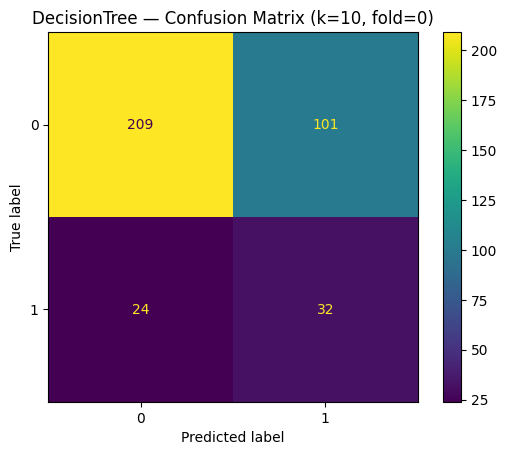

DecisionTree: TN=209, FP=101, FN=24, TP=32

DecisionTree: Accuracy = 0.658, Precision = 0.241, Recall = 0.571, F1-score = 0.339



<Figure size 400x400 with 0 Axes>

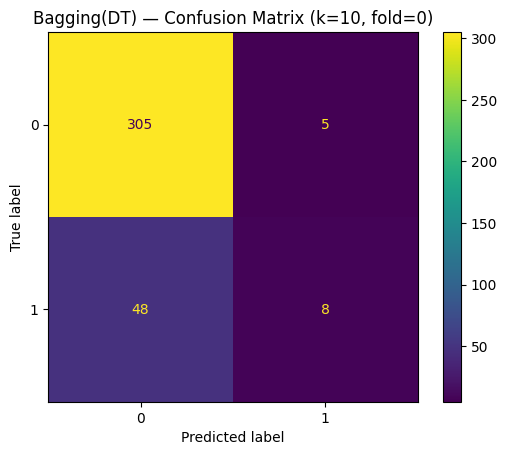

Bagging(DT): TN=305, FP=5, FN=48, TP=8

Bagging(DT): Accuracy = 0.855, Precision = 0.615, Recall = 0.143, F1-score = 0.232



<Figure size 400x400 with 0 Axes>

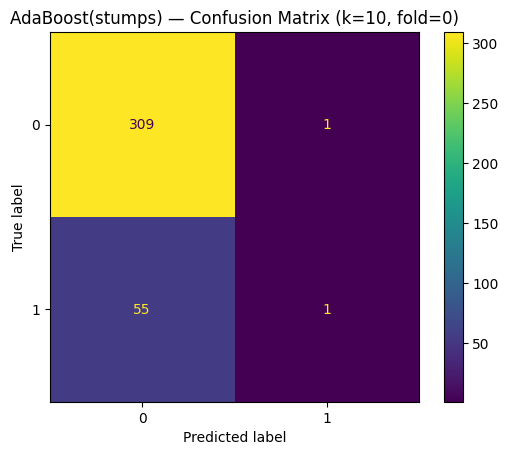

AdaBoost(stumps): TN=309, FP=1, FN=55, TP=1

AdaBoost(stumps): Accuracy = 0.847, Precision = 0.500, Recall = 0.018, F1-score = 0.034



In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models_3 = {
    "DecisionTree": clf,
    "Bagging(DT)": bagging,
    "AdaBoost(stumps)": adaboost
}

k = 10
fold_to_show = 0

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

for model_name, model in models_3.items():
    for fold_i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        if fold_i != fold_to_show:
            continue

        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_test_fold)

        cm = confusion_matrix(y_test_fold, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        plt.figure(figsize=(4, 4))
        disp.plot(values_format="d")
        plt.title(f"{model_name} — Confusion Matrix (k={k}, fold={fold_to_show})")
        plt.show()

        tn, fp, fn, tp = cm.ravel()
        print(f"{model_name}: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")
        print(f"{model_name}: Accuracy = {(tp + tn) / len(y_test_fold):.3f}, Precision = {tp / (tp + fp):.3f}, Recall = {tp / (tp + fn):.3f}, F1-score = {2 * tp / (2 * tp + fp + fn):.3f}\n")


## A statistical test (e.g., paired t-test) to determine if differences between models are significant.

To determine whether the observed differences between the three models are
statistically significant, we performed **paired t-tests** on the **F1-score**
across the same **k = 10 stratified cross-validation folds**.

**Hypotheses**
- **Null hypothesis** $H_0$: the mean F1-score difference between two models is **0**
- **Alternative hypothesis** $H_1$: the mean F1-score difference between two models is **not 0**

We use significance level $\alpha = 0.05$.

**Paired t-test results (F1):**
- **DecisionTree vs Bagging(DT)**: mean(diff) = **0.1852**, $t = 10.2594$, $p = 0.000003$
- **DecisionTree vs AdaBoost(stumps)**: mean(diff) = **0.3187**, $t = 30.7670$, $p \approx 0.000000$
- **Bagging(DT) vs AdaBoost(stumps)**: mean(diff) = **0.1335**, $t = 9.9301$, $p = 0.000004$

**Interpretation**
All three comparisons yield extremely small p-values ($p \ll 0.05$), therefore we
**reject $H_0$ in every pairwise comparison**. This indicates that the F1-score
differences between each pair of models are **statistically significant**.

Additionally, the **positive mean(diff)** values indicate that the first model
in each comparison has a higher average F1-score than the second model.
Therefore, the ranking in terms of F1-score is:

$$
\text{DecisionTree} \;>\; \text{Bagging(DT)} \;>\; \text{AdaBoost(stumps)}.
$$






In [25]:

k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

metric = "f1"

scores = {}
for name, model in models_3.items():
    scores[name] = cross_val_score(model, X, y, cv=cv, scoring=metric)

# Paired t-tests
pairs = [
    ("DecisionTree", "Bagging(DT)"),
    ("DecisionTree", "AdaBoost(stumps)"),
    ("Bagging(DT)", "AdaBoost(stumps)")
]

alpha = 0.05
print(f"Metric: {metric}, k={k}, alpha={alpha}\n")

for a, b in pairs:
    t_stat, p_val = ttest_rel(scores[a], scores[b])
    diff_mean = np.mean(scores[a] - scores[b])
    print(f"{a} vs {b}: mean(diff)={diff_mean:.4f}, t={t_stat:.4f}, p={p_val:.6f}")


Metric: f1, k=10, alpha=0.05

DecisionTree vs Bagging(DT): mean(diff)=0.1852, t=10.2594, p=0.000003
DecisionTree vs AdaBoost(stumps): mean(diff)=0.3187, t=30.7670, p=0.000000
Bagging(DT) vs AdaBoost(stumps): mean(diff)=0.1335, t=9.9301, p=0.000004


## A discussion on the trade-off between bias and variance for each model.

- Decision Tree (single model): A decision tree is a flexible non-linear model that can fit complex boundaries. This usually means low bias (it can fit the training data well) but high variance (small changes in training data can lead to very different trees). Deep trees especially tend to overfit, increasing variance and reducing generalization performance.

- Bagging (Decision Trees): Bagging trains many trees on bootstrapped samples and aggregates by voting. Averaging many high-variance learners typically reduces variance significantly while keeping bias similar to the base learner. Therefore, Bagging often improves test performance and stability compared to a single decision tree, especially when the base model is unstable (like trees).

- AdaBoost (stumps / shallow trees): Boosting builds learners sequentially, focusing more on previously misclassified samples. This tends to reduce bias (it progressively corrects systematic errors) and can yield strong performance, but it may be more sensitive to noise/outliers; depending on hyperparameters and data quality, it can increase variance or overfit if boosted too aggressively. With shallow stumps, boosting often balances complexity well, but performance can degrade if the data has label noise or hard outliers.

- Overall, the single decision tree is expected to show higher variance, Bagging mainly improves stability via variance reduction, and AdaBoost often improves accuracy/F1 by reducing bias through sequential error-correction, with a possible risk of overfitting under noisy conditions.

# Task (50 points): For the same classification problem solved above, implement the XGBoost algorithm. If you picked XGBoost as one of the boosting algorithms in task 2, you may use the same implementation. Implement and evaluate XGBoost with the following requirements:

## 1. Perform a grid search or random search over at least 3 hyperparameters, such as learning rate, max depth, and subsample.

We implemented **XGBoost** for the same binary classification problem and performed hyperparameter tuning using **RandomizedSearchCV** with **10-fold Stratified Cross-Validation**. A total of **40 hyperparameter configurations** were evaluated, resulting in **400 total model fits** (“Fitting 10 folds for each of 40 candidates”). The random search explored multiple hyperparameters, including **learning rate**, **max depth**, and **subsample** (as well as `n_estimators`, `min_child_weight`, `colsample_bytree`, and `reg_lambda`). The best configuration found was **subsample=0.8, max_depth=4, learning_rate=0.2, n_estimators=300, min_child_weight=5, colsample_bytree=0.6, reg_lambda=0**, achieving a best cross-validated **F1 score of 0.2064**.



In [32]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# Random search space (>= 3 hyperparameters; here we use several)
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "reg_lambda": [0, 1, 5, 10]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1",
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)

search.fit(X, y)

print("Best params:", search.best_params_)
print("Best CV F1:", search.best_score_)


Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best params: {'subsample': 0.8, 'reg_lambda': 0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best CV F1: 0.20635553059484618


## 2. Analyze the sensitivity of your model to changes in these parameters.

The table below have the top-performing XGBoost configurations found by the
random search (ranked by **mean CV F1-score**). The best model achieved a
**mean_test_score (F1) ≈ 0.2064** with **std_test_score ≈ 0.0922**, while its
**mean_train_score ≈ 0.8041**. This large gap between training and validation
performance indicates that XGBoost is likely **overfitting** (high variance),
meaning it fits the training folds very well but does not generalize strongly
to unseen folds.

Across the top candidates, the highest CV F1-scores were obtained using
moderate-depth trees (**max_depth = 3–5**) with **learning_rate = 0.1–0.2** and
**subsample between 0.6 and 1.0**. The best model used
**max_depth = 4**, **learning_rate = 0.2**, and **subsample = 0.8**, suggesting
that a slightly aggressive learning rate combined with subsampling helps
improve generalization. In addition, most top-performing models used relatively
large boosting rounds (**n_estimators = 200–500**), indicating that performance
benefits from multiple weak learners.

Also, we observe that strong configurations often include
feature subsampling (**colsample_bytree = 0.6 or 0.8**) and non-trivial
regularization / constraints such as **min_child_weight = 3–5**. These
hyperparameters reduce model complexity and help prevent overly specific splits,
which can reduce variance. Finally, several of the best configurations have
**reg_lambda = 0**, meaning L2-regularization was not required for the best
observed F1 in this search space; however, other candidates with larger
`reg_lambda` tended to have lower training scores, consistent with stronger
regularization reducing overfitting at the cost of weaker fitting ability.

Overall, the random search results show that XGBoost is **sensitive** to
hyperparameters controlling model complexity (e.g., `max_depth`,
`min_child_weight`) and stochastic regularization (`subsample`,
`colsample_bytree`). Small changes to these parameters can noticeably shift the
CV F1-score, and the best-performing settings reflect a trade-off between
learning capacity and generalization.


In [33]:
results = pd.DataFrame(search.cv_results_)

# Show top configurations by mean CV F1
cols_to_show = [
    "mean_test_score", "std_test_score",
    "mean_train_score", "std_train_score",
    "param_n_estimators", "param_learning_rate", "param_max_depth",
    "param_subsample", "param_colsample_bytree",
    "param_min_child_weight", "param_reg_lambda"
]

results_sorted = results.sort_values("mean_test_score", ascending=False)
results_sorted[cols_to_show].head(10)


,mean_test_score,std_test_score,mean_train_score,std_train_score,param_n_estimators,param_learning_rate,param_max_depth,param_subsample,param_colsample_bytree,param_min_child_weight,param_reg_lambda
23,0.206356,0.092152,0.804133,0.012006,300,0.2,4,0.8,0.6,5,0
20,0.206192,0.077601,0.964159,0.005046,500,0.1,5,0.6,0.8,3,0
24,0.200926,0.088698,0.698669,0.016111,200,0.1,5,0.6,0.8,3,0
16,0.196472,0.074876,0.894799,0.010920,500,0.2,3,0.8,0.8,1,0
11,0.192161,0.078455,0.481787,0.016114,200,0.2,4,1.0,1.0,10,10
4,0.188801,0.068127,0.529693,0.018753,100,0.2,5,0.8,1.0,10,1
36,0.186243,0.072272,0.356540,0.017099,300,0.2,2,1.0,0.6,5,1
25,0.185914,0.062885,0.363829,0.017496,100,0.2,4,1.0,1.0,10,5
0,0.185733,0.081442,0.527512,0.015684,200,0.2,4,0.8,0.8,10,10
6,0.185286,0.083469,0.606294,0.018382,300,0.1,4,0.8,0.8,5,0


## 3) Create plots to show the effect of each parameter on accuracy and another metric.

To visualize how XGBoost performance changes with hyperparameter settings, we
created sensitivity plots showing the relationship between each selected
parameter (**learning_rate**, **max_depth**, and **subsample**) and two
evaluation metrics: **F1-score** and **accuracy**. For each hyperparameter
value, we grouped the RandomizedSearchCV results and plotted the **mean
cross-validated score** averaged over all random-search trials using that
value. These plots highlight that the model is highly sensitive to parameter
choices: for example, **F1 increases with learning_rate** and peaks around
moderate depth (**max_depth ≈ 4**), while **accuracy is highest at smaller
learning_rate** (≈0.01–0.05) and shallower trees (**max_depth ≈ 2–3**). In
addition, increasing `subsample` generally improves both metrics, with the best
accuracy obtained at **subsample = 1.0**. Overall, the plots demonstrate that
hyperparameters can impact accuracy and F1 differently, and therefore tuning
must consider the target metric of interest.

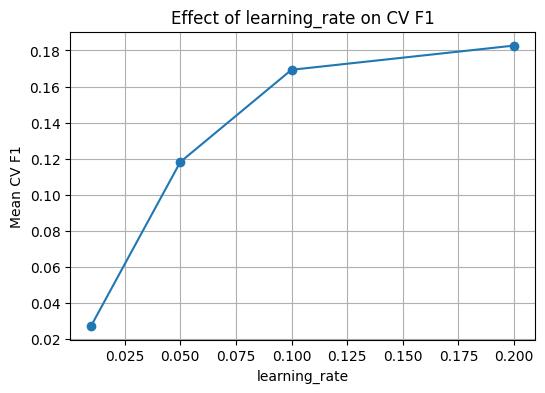

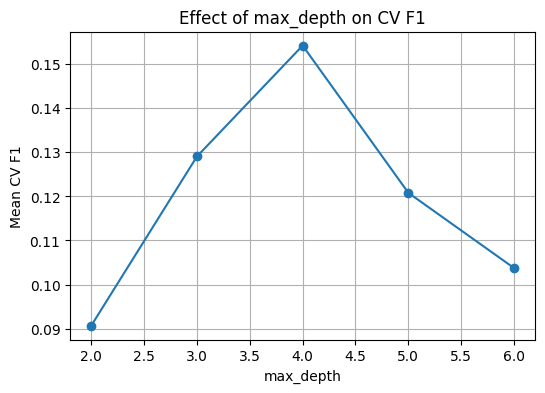

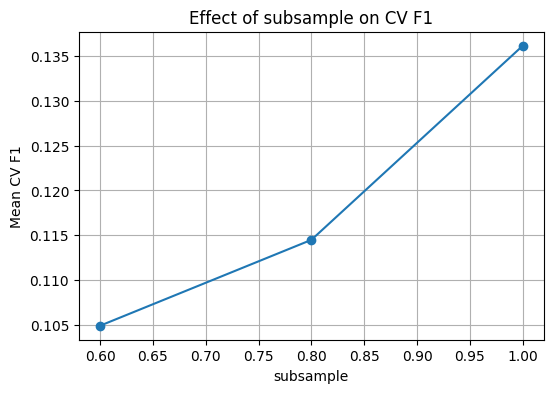

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Best params (accuracy): {'subsample': 1.0, 'reg_lambda': 5, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Best CV accuracy: 0.8498390598098661


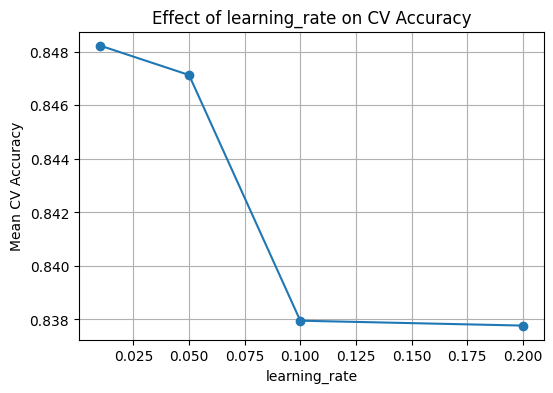

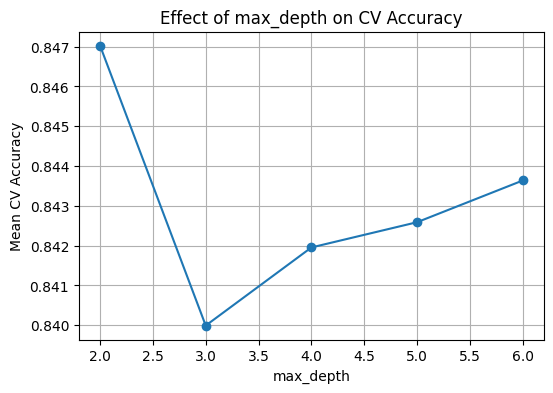

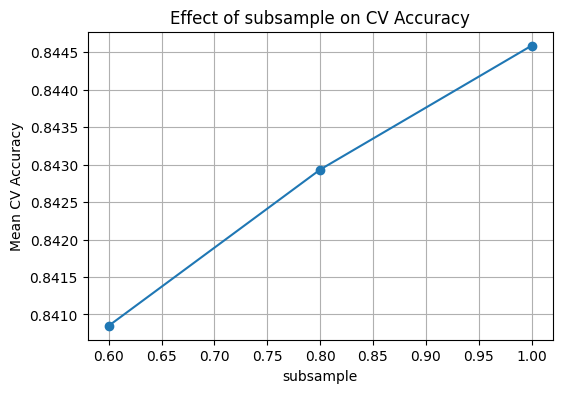

In [37]:
def sensitivity_table(results_df, param_name, score_col="mean_test_score"):
    col = f"param_{param_name}"
    tmp = results_df[[col, score_col]].copy()
    # convert possible object -> numeric when safe
    tmp[col] = pd.to_numeric(tmp[col], errors="ignore")
    out = tmp.groupby(col)[score_col].agg(["mean", "std", "count"]).reset_index()
    return out.sort_values(col)

def plot_sensitivity(tab, x_col, y_col, title, xlabel, ylabel):
    x = tab[x_col].values
    y = tab[y_col].values

    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker="o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

for p in ["learning_rate", "max_depth", "subsample"]:
    tab = sensitivity_table(results, p, score_col="mean_test_score")
    plot_sensitivity(
        tab,
        x_col=f"param_{p}",
        y_col="mean",
        title=f"Effect of {p} on CV F1",
        xlabel=p,
        ylabel="Mean CV F1"
    )

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

search_acc = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=40,
    scoring="accuracy",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

search_acc.fit(X, y)

results_acc = pd.DataFrame(search_acc.cv_results_)
print("Best params (accuracy):", search_acc.best_params_)
print("Best CV accuracy:", search_acc.best_score_)

for p in ["learning_rate", "max_depth", "subsample"]:
    tab = sensitivity_table(results_acc, p, score_col="mean_test_score")
    plot_sensitivity(
        tab,
        x_col=f"param_{p}",
        y_col="mean",
        title=f"Effect of {p} on CV Accuracy",
        xlabel=p,
        ylabel="Mean CV Accuracy"
    )

